## Example Small Sample Statistical Analysis Using Tumour $T_C$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from tqdm.notebook import tqdm

Load in ECPs

In [2]:
with open('ECP_global_C_0.1.pkl', 'rb') as f:
    ECP_global_T_C = pickle.load(f)

In [3]:
num_simplices = [ECP_global_T_C[key]['num_simplices'] for key in ECP_global_T_C]
list_of_ECP = [ECP_global_T_C[key]['contributions'] for key in ECP_global_T_C]
print(np.max(num_simplices), np.min(num_simplices), np.mean(num_simplices))

2037337 54 16211.132075471698


In [4]:
f1_max = max( [max([c[0][0] for c in contributions]) for contributions in list_of_ECP] )
f2_max = max( [max([c[0][1] for c in contributions]) for contributions in list_of_ECP] )

print(f1_max, f2_max)

0.09999744996748675 1.8361


In [5]:
from PURPLE.bifiltration_utils import EC_at_bifiltration

def subsample_ECP(contributions, f1_range, f2_range, size=51):
    
    ecp = np.zeros((size, size))
    
    for i, f1 in enumerate(np.linspace(f1_range[0], f1_range[1], num=size)):
        for j, f2 in enumerate(np.linspace(f2_range[0], f2_range[1], num=size)):
            ecp[j,i] = EC_at_bifiltration(contributions, f1, f2)
            
    return ecp

In [6]:
# Create holder arrays to load in landscapes of each cell type
cd8 = np.array([subsample_ECP(ECP_global_T_C[key]['contributions'], [0, f1_max], [0, f2_max])
       for key in tqdm(ECP_global_T_C) if "CD8" in key])

foxp3 = np.array([subsample_ECP(ECP_global_T_C[key]['contributions'], [0, f1_max], [0, f2_max])
       for key in tqdm(ECP_global_T_C) if "FoxP3" in key])

cd68 = np.array([subsample_ECP(ECP_global_T_C[key]['contributions'], [0, f1_max], [0, f2_max])
       for key in tqdm(ECP_global_T_C) if "CD68" in key])

print(cd8.shape, foxp3.shape, cd68.shape)

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

(65, 51, 51) (74, 51, 51) (73, 51, 51)


In [7]:
cd8 = cd8.reshape(-1, 51**2)
foxp3 = foxp3.reshape(-1, 51**2)
cd68 = cd68.reshape(-1, 51**2)

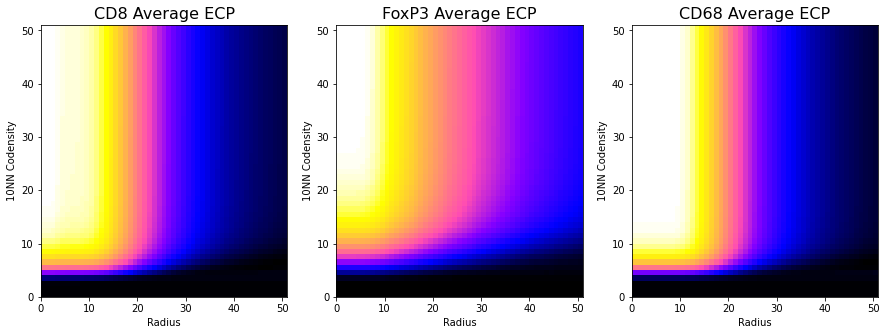

In [8]:
# Plot the average landscape for each cell type
f, axes = plt.subplots(1,3,figsize=(15,5))

for i, (celltype, landscape_holder) in enumerate(zip(['CD8', 'FoxP3','CD68'],[cd8, foxp3, cd68])):
    ax = plt.subplot(1,3,i+1)
    avg_landscape = np.mean(landscape_holder,axis = 0).reshape(51,51)
    ax.set_ylabel("10NN Codensity")
    ax.set_xlabel("Radius")
    ax.set_title(f"{celltype} Average ECP", fontsize=16)
    ax.pcolormesh(avg_landscape, cmap="gnuplot2")
    pass


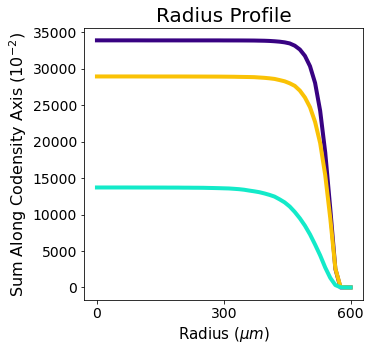

In [9]:
# Plot the radius profile
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)

plt.title("Radius Profile", fontsize=20)
avg_CD68_lscape = np.mean(cd68, axis=0).reshape(51, 51)
avg_CD8_lscape = np.mean(cd8, axis=0).reshape(51, 51)
avg_FoxP3_lscape = np.mean(foxp3, axis=0).reshape(51, 51)

ax.plot(
    np.flip(np.sum(avg_CD68_lscape, axis=1) / 51.0 * 100), c="xkcd:indigo", linewidth=4
)
ax.plot(
    np.flip(np.sum(avg_CD8_lscape, axis=1) / 51.0 * 100),
    c="xkcd:goldenrod",
    linewidth=4,
)
ax.plot(
    np.flip(np.sum(avg_FoxP3_lscape, axis=1) / 51.0 * 100), c="xkcd:aqua", linewidth=4
)
ax.set_xlabel("Radius $(\mu m)$", fontsize=15)
ax.set_ylabel("Sum Along Codensity Axis $(10^{-2})$", fontsize=16)
ax.set_xticks([0, 25, 50])
ax.set_xticklabels([0, 300, 600])
# ax.set_yticks([])
plt.tick_params(labelsize=14)

## Classify the cell types using the landscape vectors

In [10]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)

ldr_classifier = LinearDiscriminantAnalysis()
qda_classifier = QuadraticDiscriminantAnalysis()
pca_classifier = PCA()
train_split = 0.8
nbr_of_repeats = 100

In [11]:
for X, y, label in zip(
    [
        np.vstack([cd68, foxp3]),
        np.vstack([cd8, foxp3]),
        np.vstack([cd8, cd68]),
        np.vstack([cd8, foxp3, cd68]),
    ],
    [
        np.array(["CD68"] * len(cd68) + ["FoxP3"] * len(foxp3)),
        np.array(["CD8"] * len(cd8) + ["FoxP3"] * len(foxp3)),
        np.array(["CD8"] * len(cd8) + ["CD68"] * len(cd68)),
        np.array(["CD8"] * len(cd8) + ["FoxP3"] * len(foxp3) + ["CD68"] * len(cd68)),
    ],
    ["CD68vsFoxP3", "CD8vsFoxP3", "CD8vsCD68", "3way"],
):

    print(label)

    pca = PCA(n_components=3)
    Xr = pca.fit(X).transform(X)
    test_accuracy_lda = []
    test_accuracy_lda_pca = []
    test_accuracy_qda_pca = []
    mask = np.array([False] * len(y))
    mask[: int(np.floor(len(y) * train_split))] = True
    for _ in range(nbr_of_repeats):
        np.random.shuffle(mask)

        X_train = X[mask]
        Xr_train = Xr[mask]
        y_train = y[mask]

        X_test = X[np.logical_not(mask)]
        Xr_test = Xr[np.logical_not(mask)]
        y_test = y[np.logical_not(mask)]

        ldr_classifier = LinearDiscriminantAnalysis()
        ldr_classifier.fit(X_train, y_train)
        test_accuracy_lda.append(ldr_classifier.score(X_test, y_test))

        ldr_pcaclassifier = LinearDiscriminantAnalysis()
        ldr_pcaclassifier.fit(Xr_train, y_train)
        test_accuracy_lda_pca.append(ldr_pcaclassifier.score(Xr_test, y_test))

        qda_classifier = QuadraticDiscriminantAnalysis()
        qda_classifier.fit(Xr_train, y_train)
        test_accuracy_qda_pca.append(qda_classifier.score(Xr_test, y_test))

    print("lda accuracy:", np.mean(test_accuracy_lda))
    print("lda with pca accuracy:", np.mean(test_accuracy_lda_pca))
    print("qda with pca accuracy:", np.mean(test_accuracy_qda_pca))

CD68vsFoxP3
lda accuracy: 0.8943333333333335
lda with pca accuracy: 0.8970000000000001
qda with pca accuracy: 0.907666666666667
CD8vsFoxP3
lda accuracy: 0.8646428571428573
lda with pca accuracy: 0.8564285714285715
qda with pca accuracy: 0.871785714285714
CD8vsCD68
lda accuracy: 0.6485714285714286
lda with pca accuracy: 0.5982142857142858
qda with pca accuracy: 0.5878571428571429
3way
lda accuracy: 0.7316279069767441
lda with pca accuracy: 0.6411627906976746
qda with pca accuracy: 0.6558139534883722


In [ ]:
CD68vsFoxP3
lda accuracy: 0.8936666666666667
lda with pca accuracy: 0.8936666666666668
qda with pca accuracy: 0.910666666666667
CD8vsFoxP3
lda accuracy: 0.8675
lda with pca accuracy: 0.8528571428571429
qda with pca accuracy: 0.8792857142857141
CD8vsCD68
lda accuracy: 0.6839285714285714
lda with pca accuracy: 0.6057142857142858
qda with pca accuracy: 0.5614285714285714
3way
lda accuracy: 0.75
lda with pca accuracy: 0.640232558139535
qda with pca accuracy: 0.6388372093023257
